In [62]:
from datetime import date
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
df = pd.read_csv("../Resources/btcjoin.csv", parse_dates=['date'])
btc_df = yf.download('BTC-USD')
btc_df = btc_df.reset_index()
btc_df = btc_df.loc[(btc_df['Date'] > '2022-10-25')]
btc_df['Close']=btc_df['Close'].astype("float")
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
btc_df = btc_df.rename(columns={"Close": "price", "Date":"date"})
df = pd.merge(df, btc_df, on=['date', 'price'], how='outer')
df = df.rename(columns={"value": "wallets"})
df = df.drop(columns=['volume','change', 'low', 'high', 'open','Open','High','Low','Adj Close', 'Volume', 'Unnamed: 0', "wallets", "address", "mined"])
df['200D'] = df['price'].rolling(200).mean()
df['300D'] = df['price'].rolling(300).mean()
df['50D'] = df['price'].rolling(50).mean()
df = df.dropna()
df['meanavge'] = (df['200D'] + df['300D'] + df['50D'] )/3
df = df.drop(columns=['200D','300D', '50D'])
df['meanvalue'] = df["price"] - df["meanavge"]
df['status'] = df['meanvalue'].apply(lambda x: '1' if x > 0 else '0')
df['status']=df['status'].astype("object")
df['price-meanavge']=df['price'] - df['meanavge']
df['move%'] = 100*(df['price-meanavge']/(df['price'] + df['meanavge']))
bins = [-43, -18, 0, 18, 43]
group_names = ["Severely Oversold","Neutral Oversold", "Neutral Overbought","Severely Overbought"]
df["Valuation"] = pd.cut(df["move%"], bins, labels=group_names)

k = df['price'].ewm(span=12, adjust=False, min_periods=12).mean()

# Get the 12-day EMA of the closing price
d = df['price'].ewm(span=26, adjust=False, min_periods=26).mean()

# Subtract the 26-day EMA from the 12-Day EMA to get the MACD
macd = k - d

# Get the 9-Day EMA of the MACD for the Trigger line
macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()

# Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
macd_h = macd - macd_s

# Add all of our new values for the MACD to the dataframe
df['macd'] = df.index.map(macd)
df['macd_h'] = df.index.map(macd_h)
df['macd_s'] = df.index.map(macd_s)

df

[*********************100%***********************]  1 of 1 completed


date         price      meanavge    meanvalue status  \
299  2011-07-21     13.600000      8.704611     4.895389      1   
300  2011-07-22     13.700000      8.762722     4.937278      1   
301  2011-07-23     13.700000      8.796167     4.903833      1   
302  2011-07-24     14.000000      8.801778     5.198222      1   
303  2011-07-25     14.100000      8.823000     5.277000      1   
...         ...           ...           ...          ...    ...   
4494 2023-02-11  21870.875000  20801.204381  1069.670619      1   
4495 2023-02-12  21788.203125  20811.062983   977.140142      1   
4496 2023-02-13  21808.101562  20818.884033   989.217529      1   
4497 2023-02-14  22220.804688  20830.360213  1390.444475      1   
4498 2023-02-15  24307.841797  20864.116115  3443.725681      1   

      price-meanavge      move%            Valuation        macd      macd_h  \
299         4.895389  21.947878  Severely Overbought         NaN         NaN   
300         4.937278  21.979873  Severely Overbought         NaN         NaN   
301         4.903833  21.798529  Severely Overbought         NaN         NaN   
302         5.198222  22.797443  Severely Overbought         NaN         NaN   
303         5.277000  23.020547  Severely Overbought         NaN         NaN   
...              ...        ...                  ...         ...         ...   
4494     1069.670619   2.506723   Neutral Overbought  436.022594 -374.477675   
4495      977.140142   2.293796   Neutral Overbought  344.576495 -372.739019   
4496      989.217529   2.320637   Neutral Overbought  270.591234 -357.379424   
4497     1390.444475   3.229749   Neutral Overbought  242.464099 -308.405247   
4498     3443.725681   7.623592   Neutral Overbought  384.151337 -133.374408   

          macd_s  
299          NaN  
300          NaN  
301          NaN  
302          NaN  
303          NaN  
...          ...  
4494  810.500269  
4495  717.315514  
4496  627.970658  
4497  550.869346  
4498  517.525744  

[4200 rows x 11 columns]

21:57:51 - cmdstanpy - INFO - Chain [1] start processing
21:57:55 - cmdstanpy - INFO - Chain [1] done processing


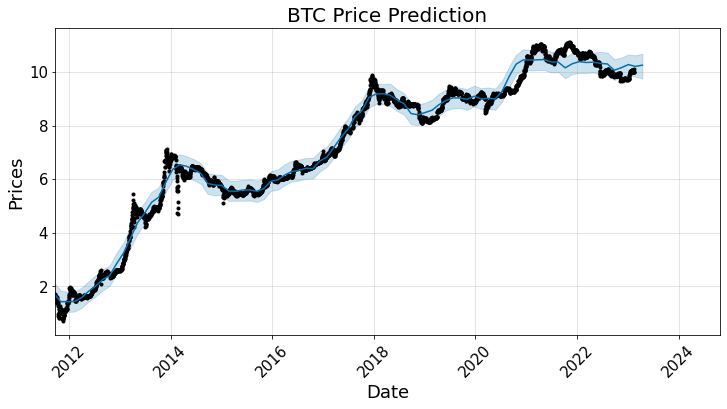

In [63]:
## Combine with Prophet
from datetime import timedelta, date
from prophet import Prophet
df['priceL'] = np.log(df['price'])

df_train = df[['date', 'priceL']]
df_train = df_train.rename(columns = {"date":"ds", "priceL":"y"})

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(df_train);

start = "2010-09-25"
end = date.today() + timedelta(days=60)
insample = pd.DataFrame(pd.date_range(start,end, periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)

# Plot
fig = model.plot(prediction, figsize=(10,5))
ax = fig.gca()
ax.set_title("BTC Price Prediction", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("Prices", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2011-09-25', '2024-10-24'])) 
plt.show();

In [81]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="Valuation", color_discrete_sequence=["green","blue","orange","red"],
                 title="price")
fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))
fig.add_trace(go.Scatter(x=prediction['ds'], y=np.exp(prediction['yhat']),
    fill=None,
    mode='lines',
    line_color='lightblue',
    ))
fig.add_trace(go.Scatter(
    x=prediction['ds'],
    y=np.exp(prediction['yhat_lower']),
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='lightblue'))

fig.add_trace(go.Scatter(
    x=prediction['ds'],
    y=np.exp(prediction['yhat_upper']),
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='lightblue'))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Prophet Model + Buy Zones')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")
fig.layout.template = 'seaborn'	
fig.show()
fig.write_html('../static/combo.html')

In [82]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.bar(df, x="date", y="price", color="Valuation", color_discrete_sequence=["green","blue","orange","red"],
                 title="price")
fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Buy Zones 2.0')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.update_layout(showlegend=True)
fig.update_traces(dict(marker_line_width=.01))
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/buyzones2.html')

In [83]:
from datetime import date
from datetime import datetime

d1 = str(int(df.price[df['date']=='2014-01-06'].tolist()[0]/df.price[df['date']=='2011-11-25'].tolist()[0]*100)) +"%"
d2 = str(int(-100*(1-(df.price[df['date']=='2015-10-05'].tolist()[0]/df.price[df['date']=='2014-01-07'].tolist()[0])))) + "%"
d3 = str(int(df.price[df['date']=='2018-01-06'].tolist()[0]/df.price[df['date']=='2015-10-06'].tolist()[0]*100)) +"%"
d4 = str(int(-100*(1-(df.price[df['date']=='2019-03-30'].tolist()[0]/df.price[df['date']=='2018-01-07'].tolist()[0])))) + "%"
d5 = str(int(df.price[df['date']=='2021-11-08'].tolist()[0] / df.price[df['date']=='2019-04-01'].tolist()[0] *100)) + "%"
d6 = str(int(-100*(1-(df.price[df['date']== df.date.iloc[-1]].tolist()[0]/df.price[df['date']=='2021-11-09'].tolist()[0])))) + "%"
d7 = str(int(-100*(1-(df.price[df['date']== df.date.iloc[-1]].tolist()[0]/df.price[df['date']=='2023-01-14'].tolist()[0])))) + "%"

import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="Valuation", color_discrete_sequence=["green","blue","orange","red"],
                 title="price")
fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))
fig.add_trace(go.Scatter(x=prediction['ds'], y=np.exp(prediction['yhat']),
    fill=None,
    mode='lines',
    line_color='lightblue',
    ))
fig.add_trace(go.Scatter(
    x=prediction['ds'],
    y=np.exp(prediction['yhat_lower']),
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='lightblue'))

fig.add_trace(go.Scatter(
    x=prediction['ds'],
    y=np.exp(prediction['yhat_upper']),
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='lightblue'))

fig.add_vrect(x0="2011-11-25", x1="2014-01-06", 
              annotation_text=str((date(2014, 2, 4)-date(2011, 11, 25)).days) + " days " + str(d1), annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2014-01-07", x1="2015-10-05", 
              annotation_text=str((date(2015, 10, 7)-date(2014, 2, 5)).days) + " days " + str(d2), annotation_position="top left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="red", opacity=0.25, line_width=0)
fig.add_vrect(x0="2015-10-06", x1="2018-01-06", 
              annotation_text=str((date(2018, 1, 18)-date(2015, 10, 6)).days) +" days " + str(d3), annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2018-01-07", x1="2019-03-30", 
              annotation_text=str((date(2019, 3, 30)-date(2018, 1, 18)).days) + " days " + str(d4), annotation_position="top left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="red", opacity=0.25, line_width=0)
fig.add_vrect(x0="2019-04-01", x1="2021-11-08", 
              annotation_text=str((date(2021, 11, 8)-date(2019, 4, 1)).days) + " days " + str(d5), annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2021-11-09", x1=("2023-01-14"), 
              annotation_text=str((date.today() -date(2021, 11, 8)).days) + " days " + str(d6), annotation_position="top left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="red", opacity=0.25, line_width=0)
fig.add_vrect(x0="2023-01-14", x1=(f'{datetime.today():%Y-%m-%d}'), 
              annotation_text=str((date.today() -date(2023, 1, 14)).days) + " days " + str(d7), annotation_position="left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0=(f'{datetime.today():%Y-%m-%d}'), x1="2024-04-02", 
              annotation_text=str((date(2024, 4, 2)-date.today()).days) + " days halving", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)

fig.add_trace(go.Scatter(
    x=[(date(2021, 11, 8)),(date(2021, 11, 8) +timedelta(days=1079))],
    y=[df.price[df['price']==df.price.max()].tolist()[0],df.price[df['price']==df.price.max()].tolist()[0]],
    mode="markers+text+lines",
    name="Lines and Text",
    text=[ " ",str(df.price[df['price']==df.price.max()].tolist()[0]) + " " + str((date(2021, 11, 8) +timedelta(days=1079)))],
    textposition="bottom center"
))

fig.update_layout(showlegend=False)
fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Prophet Model + Buy Zones + Bull/Bear')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=15, t=70, b=20),
)
fig.add_vline(x='2012-11-28', line_width=1, line_dash="dash", line_color="black")
fig.add_vline(x='2016-07-09', line_width=1, line_dash="dash", line_color="black")	
fig.add_vline(x='2020-05-11', line_width=1, line_dash="dash", line_color="black")	
fig.add_vline(x='2024-04-02', line_width=1, line_dash="dash", line_color="black")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/combodates.html')

In [67]:
df['status'] = df['status'].replace({'0': 'Under'})
df['status'] = df['status'].replace({'1': 'Over'})

In [68]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="status", color_discrete_sequence=["orange", "red"], trendline="expanding", trendline_options=dict(function="max"), 
                 title="price")

fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Expanding Mean + Time To Reach Previous ATH')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)

fig.add_vrect(x0="2017-03-17", x1="2013-11-29", 
              annotation_text=str((date(2017, 3, 17)-date(2013, 11, 29)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2017-12-17", x1="2020-11-30", 
              annotation_text=str((date(2020, 11, 30)-date(2017, 12, 17)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2021-11-08", x1=(f'{datetime.today():%Y-%m-%d}'), 
              annotation_text=str((date.today()-date(2021, 11, 8)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0=(f'{datetime.today():%Y-%m-%d}'), x1="2024-04-02", 
              annotation_text=str((date(2024, 4, 2)-date.today()).days) + " days halving", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="red", opacity=0.25, line_width=0)

fig.add_trace(go.Scatter(
    x=[(date(2021, 11, 8)),(date(2021, 11, 8) +timedelta(days=1079))],
    y=[df.price[df['price']==df.price.max()].tolist()[0],df.price[df['price']==df.price.max()].tolist()[0]],
    mode="markers+text+lines",
    name="Lines and Text",
    text=[ " ",str(df.price[df['price']==df.price.max()].tolist()[0]) + " " + str((date(2021, 11, 8) +timedelta(days=1079)))],
    textposition="bottom center"
))

fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/Bitcoinvaluestatus.html')

In [69]:
## Approximate date/time to reach previous ATH

import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="status", color_discrete_sequence=["orange", "red"], trendline="expanding", trendline_options=dict(function="max"), 
                 title="price")

fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))
# fig.add_trace(go.Scatter(name="Middle Bound", x=prediction['ds'],  mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat']), legendrank=2))
# fig.add_trace(go.Scatter(name="Lower Bound", x=prediction['ds'],  mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat_lower']), legendrank=1))
# fig.add_trace(go.Scatter(name="Upper Bound", x=prediction['ds'], mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat_upper']), legendrank=1))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Cycle Tops')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)

fig.add_vrect(x0="2017-03-17", x1="2013-11-29", 
              annotation_text=str((date(2017, 3, 17)-date(2013, 11, 29)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2017-12-17", x1="2020-11-30", 
              annotation_text=str((date(2020, 11, 30)-date(2017, 12, 17)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2021-11-08", x1=(f'{datetime.today():%Y-%m-%d}'), 
              annotation_text=str((date.today()-date(2021, 11, 8)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0=(f'{datetime.today():%Y-%m-%d}'), x1="2024-10-22", 
              annotation_text=str((date(2024, 10, 22) - date.today()).days) + " days previous ATH", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="blue", opacity=0.25, line_width=0)

fig.add_trace(go.Scatter(
    x=[(date(2021, 11, 8)),(date(2021, 11, 8) +timedelta(days=1079))],
    y=[df.price[df['price']==df.price.max()].tolist()[0],df.price[df['price']==df.price.max()].tolist()[0]],
    mode="markers+text+lines",
    name="Lines and Text",
    text=[ " ",str(df.price[df['price']==df.price.max()].tolist()[0]) + " " + str((date(2021, 11, 8) +timedelta(days=1079)))],
    textposition="bottom center"
))


fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/approximatenextath.html')

In [70]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="status", color_discrete_sequence=["orange", "red"], trendline="expanding", trendline_options=dict(function="max"), 
                 title="price")

fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Expanding Mean + Meanaverage')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)

fig.add_vrect(x0="2011-09-04", x1="2012-05-16", 
              annotation_text=str((date(2012, 5, 16)-date(2011, 9, 4)).days) + " days", annotation_position="top left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2012-05-17", x1="2014-02-10", 
              annotation_text=str((date(2014, 2, 10)-date(2012, 5, 17)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2014-02-11", x1="2015-10-06", 
              annotation_text=str((date(2015, 10, 6)-date(2014, 2, 11)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2015-10-07", x1="2018-02-18", 
              annotation_text=str((date(2018, 2, 18)-date(2015, 10, 7)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2018-02-19", x1="2019-04-02", 
              annotation_text=str((date(2019, 4, 2)-date(2018, 2, 19)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2019-04-03", x1="2021-11-07", 
              annotation_text=str((date(2021, 11, 7)-date(2019, 4, 3)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2021-11-08", x1=("2023-01-14"), 
              annotation_text=str((date.today()-date(2021, 11, 8)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2023-01-14", x1=(f'{datetime.today():%Y-%m-%d}'), 
              annotation_text=str((date.today()-date(2023, 1, 14)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
# fig.add_vrect(x0=(f'{datetime.today():%Y-%m-%d}'), x1="2024-04-02", 
#               annotation_text=str((date(2024, 4, 2)-date.today()).days) + " days halving", annotation_position="bottom left",
#               annotation=dict(font_size=15, font_family="Times New Roman"),
#               fillcolor="red", opacity=0.25, line_width=0)

fig.add_trace(go.Scatter(
    x=[(date(2021, 11, 8)),(date(2021, 11, 8) +timedelta(days=1079))],
    y=[df.price[df['price']==df.price.max()].tolist()[0],df.price[df['price']==df.price.max()].tolist()[0]],
    mode="markers+text+lines",
    name="Lines and Text",
    text=[ " ",str(df.price[df['price']==df.price.max()].tolist()[0]) + " " + str((date(2021, 11, 8) +timedelta(days=1079)))],
    textposition="top center"
))
        

fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/Bitcoinvaluestatus2.html')

In [85]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.bar(df, x="date", y="price", color="status", color_discrete_sequence=["orange", "red"], 
                 title="price")

fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Under vs Over')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)

fig.update_traces(dict(marker_line_width=.01))


fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/overunder.html')

In [72]:
df=df.dropna()
df_tail = df.tail(180)
df_tail.head()

date    price      meanavge    meanvalue status  price-meanavge  \
4319 2022-08-20  21138.9  31113.325000 -9974.425000  Under    -9974.425000   
4320 2022-08-21  21517.2  31056.696889 -9539.496889  Under    -9539.496889   
4321 2022-08-22  21416.3  31001.070944 -9584.770944  Under    -9584.770944   
4322 2022-08-23  21517.2  30935.306389 -9418.106389  Under    -9418.106389   
4323 2022-08-24  21365.2  30866.084111 -9500.884111  Under    -9500.884111   

          move%          Valuation        macd      macd_h      macd_s  \
4319 -19.088996  Severely Oversold  -87.141762 -355.530233  268.388471   
4320 -18.144930  Severely Oversold -191.079888 -367.574687  176.494799   
4321 -18.285486  Severely Oversold -278.384346 -363.903317   85.518970   
4322 -17.955494   Neutral Oversold -335.563802 -336.866218    1.302416   
4323 -18.190026  Severely Oversold -388.663787 -311.972963  -76.690825   

        priceL  
4319  9.958870  
4320  9.976608  
4321  9.971908  
4322  9.976608  
4323  9.969519

In [91]:
import pandas_ta as pta
df_tail['RSI'] = pta.rsi(df_tail['price'], length = 14)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=4, cols=1,shared_xaxes=True,vertical_spacing=0.01, row_heights=[0.2, 0.05,0.05,0.05])

fig.add_trace(
    go.Scatter(name="Price",x=df_tail['date'], y=df_tail['price'],
        marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=1, col=1)


fig.add_trace(
    go.Bar(name="macd",x=df_tail['date'], y=df_tail['macd'],
    marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_s",x=df_tail['date'], y=df_tail['macd_s'],
    marker=dict(color=df_tail['macd_s'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_h",x=df_tail['date'], y=df_tail['macd_h'],
    marker=dict(color=df_tail['macd_h'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(go.Bar(x=df_tail['date'], y=df_tail['move%'],
                    marker=dict(color=df_tail['move%'], coloraxis="coloraxis2")),
              3, 1)

fig.add_trace(
    go.Scatter(name="RSI",x=df_tail['date'], y=df_tail['RSI'],
    marker=dict(color=df_tail['RSI'], coloraxis="coloraxis3")),
    row=4, col=1)

fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=50)
fig.update_layout(coloraxis1=dict(colorscale='Bluered_r'), showlegend=False)
fig.update_layout(coloraxis2=dict(colorscale='Bluered_r'), showlegend=False)
fig.update_layout(coloraxis3=dict(colorscale='Bluered_r'), showlegend=False)
fig.update_layout(coloraxis1_showscale=False)
fig.update_layout(coloraxis2_showscale=False)
fig.update_layout(height=900, width=1000, title_text="180 Day MACD, RSI, Price and Move%")
fig.update_layout(template='plotly_dark')
fig.show()
fig.write_html('../static/macd&move.html')

C:\Users\16474\AppData\Local\Temp\ipykernel_19688\2211191892.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [74]:
_d

NameError: name '_d' is not defined